In [1]:
from pylab import *  
import numpy as np

In [2]:
#--- precipitable water vapor (g/cm2)
uw = [0.75,1.0,1.25,1.5,1.75,2.0]

#--- surface temperature (K)
#btemp = [293]

In [3]:
def read_sbdart_data(filename):
    f_raw = loadtxt(filename,delimiter="\t",skiprows=3,dtype='str')
    f = f_raw[::3]

    WL=[] #--- wavelength (um)
    FFV=[] #--- filter value
    TOPDN=[] #--- downwelling flux to the top of the atmosphere (TOA, W/cm2/um)
    TOPUP=[] #--- TOA upwelling flux
    TOPDIR=[] #--- TOA direct flux
    BOTDN=[] #--- downwelling flux at surface
    BOTUP=[] #--- upwelling flux at surface
    BOTDIR=[] #--- direct flux at surface

    for row in f:
        row = row[1:]
        row = row.replace('  ',' ')
        row = row.lstrip()
        split_row = row.split(' ')
        #print(split_row)
    
        WL.append(float(split_row[0]))
        FFV.append(float(split_row[1]))
        TOPDN.append(float(split_row[2]))
        TOPUP.append(float(split_row[3]))
        TOPDIR.append(float(split_row[4]))
        BOTDN.append(float(split_row[5]))
        BOTUP.append(float(split_row[6]))
        BOTDIR.append(float(split_row[7]))

    return TOPUP

In [4]:
flux_lw_293 = read_sbdart_data('figure/result_11um_293k')
flux_sw_293 = read_sbdart_data('figure/result_39um_293k')
flux_lw_283 = read_sbdart_data('figure/result_11um_283k')
flux_sw_283 = read_sbdart_data('figure/result_39um_283k')

In [5]:
flux_lw_283

[22.856, 22.801, 22.735, 22.658, 22.571, 22.474]

In [6]:
flux_sw_283

[0.82965, 0.82851, 0.82736, 0.8262, 0.82502, 0.82384]

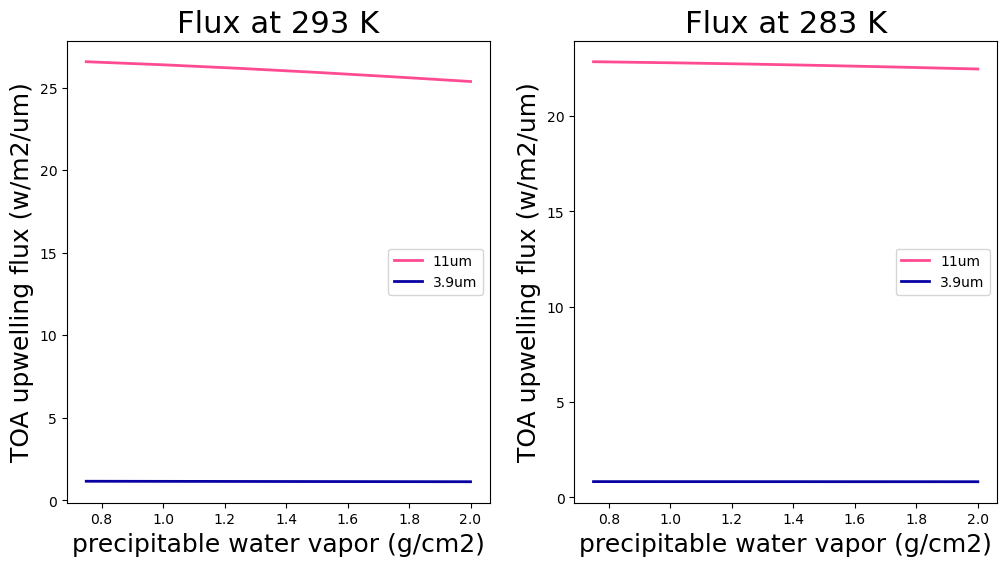

In [7]:
fig,ax=plt.subplots(1,2, figsize=(12,6))
ax[0].set_ylabel("TOA upwelling flux (w/m2/um)", size=18)
ax[0].set_xlabel("precipitable water vapor (g/cm2)", size=18)
ax[0].set_title("Flux at 293 K", size=22)
ax[0].plot(uw, flux_lw_293, c='#FF4B91', linewidth=2, label="11um")
ax[0].plot(uw, flux_sw_293, c='#0802A3', linewidth=2, label="3.9um")
ax[0].legend()

ax[1].set_ylabel("TOA upwelling flux (w/m2/um)", size=18)
ax[1].set_xlabel("precipitable water vapor (g/cm2)", size=18)
ax[1].set_title("Flux at 283 K", size=22)
ax[1].plot(uw, flux_lw_283, c='#FF4B91', linewidth=2, label="11um")
ax[1].plot(uw, flux_sw_283, c='#0802A3', linewidth=2, label="3.9um")
ax[1].legend()

#plt.savefig('total_upward_flux.png', dpi=200, bbox_inches='tight')
plt.show()

#### Calculate the brightness temperature difference: 

* sbdart gives the flux density in w/m2/micron
* this can be easily converted to brightness temperature ($T_B$) with Raleigh-Jean's law: $T_B = \frac{\lambda^2}{2k\Omega}S$
    * $\lambda$: wavelength
    * $k$: Boltzmann constant
    * $\Omega$: beam solid angle
    * $S$: flux density
 
* might actually be a different equation

In [8]:
c1 = 3.74e-16 #W m-2
c2 = 1.44e-2 #K
wl = 11e-6 #m
S = np.array(flux_lw_283) #W m-2 um-1

T_b_lw = (c2/wl) * np.log(( (c1*(wl**-5)) / S)+1)
T_b_lw

array([24135.16829795, 24138.32225174, 24142.11705408, 24146.5582717 ,
       24151.59446743, 24157.23247446])

In [9]:
c1 = 3.74e-16 #W m-2
c2 = 1.44e-2 #K
wl = 3.9e-6 #m
S = np.array(flux_sw_283) #W m-2 um-1

T_b_sw = (c2/wl) * np.log(( (c1*(wl**-5)) / S)+1)
T_b_sw

array([99460.22954415, 99465.30653483, 99470.43514339, 99475.61557546,
       99480.8927933 , 99486.17756437])

In [10]:
BTD = T_b_lw-T_b_sw

In [11]:
BTD

array([-75325.0612462 , -75326.98428309, -75328.31808931, -75329.05730376,
       -75329.29832586, -75328.94508992])